In [22]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import torch
import eugene as eu
import matplotlib.pyplot as plt

In [7]:
# Load and preprocess the data
sdata = eu.datasets.random1000()
eu.pp.ohe_seqs_sdata(sdata)
eu.pp.train_test_split_sdata(sdata)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added
SeqData object modified:
    seqs_annot:
        + train_val


In [24]:
# Instantiate the model
model = eu.models.TutorialCNN(input_len=100, output_dim=2, task="regression", metric="explainedvariance")
eu.models.init_weights(model)
model.summary()

Model: TutorialCNN
Sequence length: 100
Output dimension: 2
Strand: ss
Task: regression
Aggregation of strands: avg
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: None
	Scheduler parameters: {}
Metric: explainedvariance
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type              | Params
---------------------------------------------------
0 | train_metric | ExplainedVariance | 0     
1 | val_metric   | ExplainedVariance | 0     
2 | test_metric  | ExplainedVariance | 0     
3 | conv1        | Conv1d            | 2.6 K 
4 | dense        | Linear            | 62    
---------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)

In [25]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
# Train the model
eu.train.fit(
    model,
    sdata,
    target_keys=["activity_0", "activity_1"],
    num_workers=4,
    gpus=0,
    batch_size=32,
    drop_last=False
)

Global seed set to 13
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | train_metric | ExplainedVariance | 0     
1 | val_metric   | ExplainedVariance | 0     
2 | test_metric  | ExplainedVariance | 0     
3 | conv1        | Conv1d            | 2.6 K 
4 | dense        | Linear            | 62    
---------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [47]:
# Generate predictions
eu.evaluate.predictions(
    model,
    sdata,
    target_keys=["activity_0", "activity_1"],
    num_workers=4,
    gpus=0,
    batch_size=32
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize.


Predicting: 0it [00:00, ?it/s]

In [49]:
# Split the data into train and validation sets
sdata_train = sdata[sdata.seqs_annot["train_val"] == True]
sdata_val = sdata[sdata.seqs_annot["train_val"] == False]

In [50]:
# Get the true and predicted values
true = torch.Tensor(sdata_val["activity_0"].values).long()
preds = torch.Tensor(sdata_val["activity_0_predictions"].values)
#preds = model(torch.Tensor(sdata_train.ohe_seqs)).squeeze(dim=1)
model.loss_fxn(preds, true), model.val_metric(preds, true)

(tensor(0.2922), tensor(0.))

In [51]:
# Get the true and predicted values
true = torch.Tensor(sdata_val["activity_1"].values).long()
preds = torch.Tensor(sdata_val["activity_0_predictions"].values)
#preds = model(torch.Tensor(sdata_train.ohe_seqs)).squeeze(dim=1)
model.loss_fxn(preds, true), model.val_metric(preds, true)

(tensor(0.2922), tensor(0.))

In [52]:
true = torch.Tensor(sdata_train["activity_0"].values).long()
preds = torch.Tensor(sdata_train["activity_0_predictions"].values)
#preds = model(torch.Tensor(sdata_train.ohe_seqs)).squeeze(dim=1)
model.loss_fxn(preds, true), model.train_metric(preds, true)


(tensor(0.2564), tensor(0.))

In [53]:
true = torch.Tensor(sdata_train["activity_1"].values).long()
preds = torch.Tensor(sdata_train["activity_1_predictions"].values)
#preds = model(torch.Tensor(sdata_train.ohe_seqs)).squeeze(dim=1)
model.loss_fxn(preds, true), model.train_metric(preds, true)


(tensor(0.2604), tensor(0.))

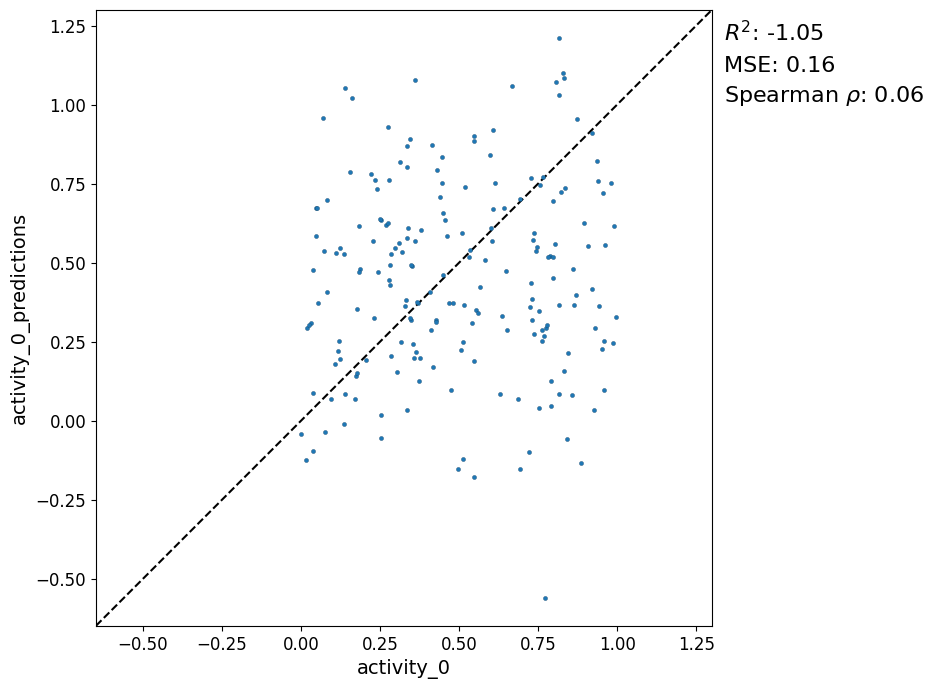

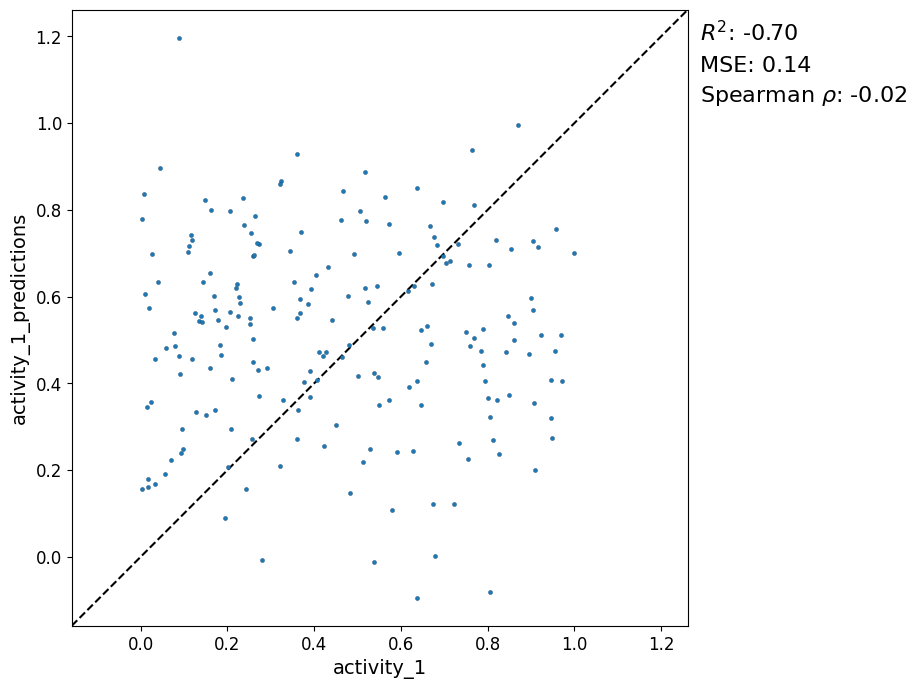

In [62]:
eu.pl.performance_scatter(
    sdata_val,
    target_keys=["activity_0", "activity_1"],
    prediction_keys=["activity_0_predictions", "activity_1_predictions"],
)
plt.show()

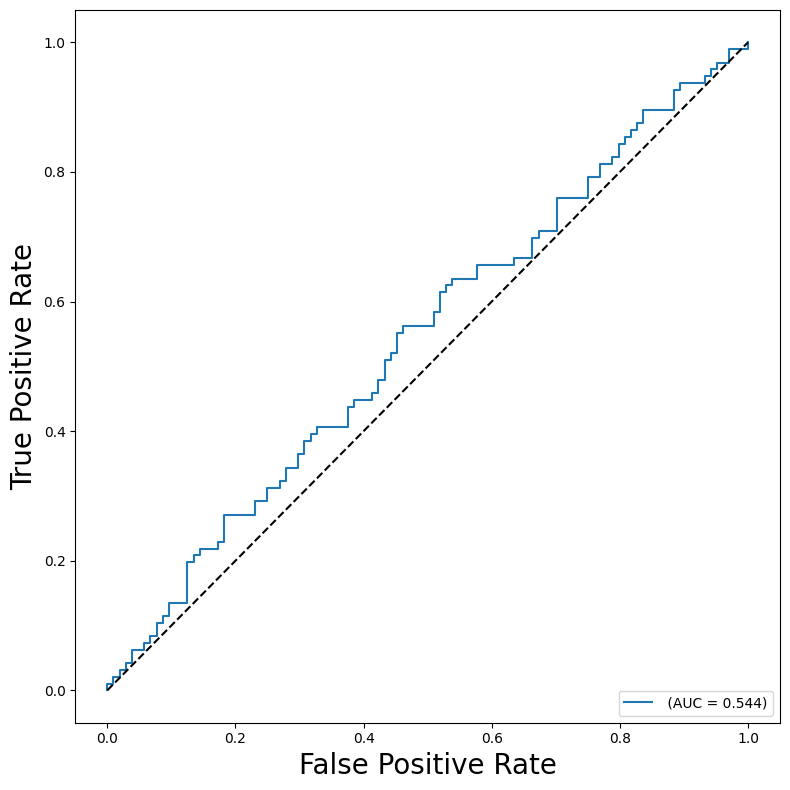

In [153]:
eu.pl.auroc(
    sdata_val,
    target_keys="label_0",
    prediction_keys="label_0_predictions"
)
plt.show()

---

# Scratch

# Metrics

In [ ]:
import torchmetrics
from torchmetrics import Metric

In [ ]:
from torchmetrics import Metric

class MyAccuracy(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds, target = self._input_format(preds, target)
        assert preds.shape == target.shape

        self.correct += torch.sum(preds == target)
        self.total += target.numel()

    def compute(self):
        return self.correct.float() / self.total

In [ ]:
metric = MyAccuracy()

/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (MyAccuracy). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [ ]:
metric.__class__.__name__.lower()

'myaccuracy'

In [ ]:
from eugene.models.base._sequence_models import CNN

In [ ]:
model = CNN(
    input_len=100,
    output_dim=1,
    strand="ss",
    aggr="max",
    task="binary_classification",
    optimizer="adam",
    conv_kwargs={
        "conv_channels": [10, 10],
        "conv_kernels": [5, 3],
        "activations": "relu",
        "pool_types": "max"
    },
    scheduler="reduce_lr_on_plateau",
    metric="accuracy",
    seed=13
)
model

[autoreload of eugene.models failed: Traceback (most recent call last):
  File "/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/importlib/__init__.py", line 160, in reload
    name=parent_name) from None
ImportError: parent 'eugene' not in sys.modules
]
Global seed set to 13


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
model.configure_optimizers()

{'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'lr_scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x7fbe3e911bd0>,
 'monitor': 'val_loss'}

In [ ]:
model.lr_schedulers()

AttributeError: 'NoneType' object has no attribute 'lr_schedulers'

In [ ]:
from eugene.datasets._datasets import random1000
from eugene.preprocess import ohe_seqs_sdata

In [ ]:
sdata = random1000()
sdata

SeqData object with = 1000 seqs
seqs = (1000,)
names = (1000,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'activity_0', 'activity_1', 'activity_2', 'activity_3', 'activity_4', 'activity_5', 'activity_6', 'activity_7', 'activity_8', 'activity_9'
pos_annot: None
seqsm: None
uns: None

In [ ]:
ohe_seqs_sdata(sdata)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added


In [ ]:
sdataset = sdata.to_dataset(target_keys="label_0")

No transforms given, assuming just need to tensorize.


In [ ]:
sdataloader = sdataset.to_dataloader(batch_size=128, shuffle=False)
ID, x, x_rev_comp, y = next(iter(sdataloader))

In [ ]:
model.metric.reset()
metric_vals = []
for batch_idx, batch in enumerate(sdataloader):
    ID, x, x_rev_comp, y = batch
    outs = model(x, x_rev_comp=None).squeeze(dim=1)
    loss = model.loss_fxn(outs, y)
    print(f"Loss is {loss}", end=", ")
    met = model.metric(outs, y.long())
    print(f"{model.metric_name} is {met} at batch {batch_idx}")
    metric_vals.append(met)
    if batch_idx == 5:
        break

Loss is 0.5474207401275635, accuracy is 0.515625 at batch 0
Loss is 0.5789369344711304, accuracy is 0.4765625 at batch 1
Loss is 0.5303661823272705, accuracy is 0.5234375 at batch 2
Loss is 0.6017324924468994, accuracy is 0.453125 at batch 3
Loss is 0.5952660441398621, accuracy is 0.46875 at batch 4
Loss is 0.5732230544090271, accuracy is 0.484375 at batch 5


In [ ]:
model.metric

Accuracy()

In [ ]:
model.loss_fxn

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Union[bool, NoneType] = None, reduce: Union[bool, NoneType] = None, reduction: str = 'mean') -> torch.Tensor>

In [ ]:
model.optimizer

torch.optim.adam.Adam

In [ ]:
model.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
model.scheduler

In [ ]:
from torchmetrics.functional.classification import binary_accuracy

In [ ]:
model.metric.

In [ ]:
all_preds = torch.concat(model.metric.pred)
all_targets = torch.concat(model.metric.target)
binary_accuracy(all_preds, all_targets)

AttributeError: 'Accuracy' object has no attribute 'pred'

In [ ]:
model.metric.compute()

tensor(0.4870)

In [ ]:
torch.mean(torch.Tensor(metric_vals))

tensor(0.4870)

In [ ]:
model.calculate_metrics(probs, y)

tensor(0.5029)

tensor(0.4725)

In [ ]:
batch[1].shape, batch[3].shape

(torch.Size([10, 4, 100]), torch.Size([10, 1]))

In [ ]:
model._common_step(batch=batch, batch_idx=0, optimizer_idx=0, stage="train")

tensor(0.2946, grad_fn=<MseLossBackward0>)


/Users/adamklie/Desktop/EUGENe/eugene/models/base/_base_models.py:162: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_fxn(outs, y)


TypeError: log() missing 2 required positional arguments: 'name' and 'value'

In [ ]:
model.log_dict

<bound method LightningModule.log_dict of CNN(
  (metric): AUROC()
  (conv1d_block): Conv1DBlock(
    (layers): Sequential(
      (0): Conv1d(4, 10, kernel_size=(5,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=valid)
      (4): ReLU()
      (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=940, out_features=1, bias=True)
    )
  )
)>

In [ ]:
model.lr_schedulers()

AttributeError: 'NoneType' object has no attribute 'lr_schedulers'

In [ ]:
model.lr_schedulers()

AttributeError: 'NoneType' object has no attribute 'lr_schedulers'